# Assignment 04

Sabrina Minaya Vasquez (Boston University)  
October 8, 2025

# 1. Load Dataset

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/assignment-04-Sabrina1211/data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/05 02:08:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---


25/10/05 02:08:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

In [2]:
# Missing Value Treatment

from pyspark.sql import Window  # (not used here but fine to keep)
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, isnan, count, expr

# 1) Overall median salary
overall_median_salary = df.approxQuantile("SALARY", [0.5], 0.01)[0]

# 2) Median salary by EMPLOYMENT_TYPE
median_by_employment_type = (
    df.groupBy("EMPLOYMENT_TYPE")
      .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))
)

# 3) Median salary by EMPLOYMENT_TYPE_NAME
median_by_employment_type_name = (
    df.groupBy("EMPLOYMENT_TYPE_NAME")
      .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))
)

# 4) Impute SALARY: prefer EMPLOYMENT_TYPE median, then EMPLOYMENT_TYPE_NAME median, else overall median
df_salary_imputed = (
    df.join(median_by_employment_type, on="EMPLOYMENT_TYPE", how="left")
      .join(median_by_employment_type_name, on="EMPLOYMENT_TYPE_NAME", how="left")
      .withColumn(
          "SALARY",
          F.when(
              col("SALARY").isNull(),
              F.coalesce(
                  col("median_salary_emp_type"),
                  col("median_salary_emp_type_name"),
                  F.lit(overall_median_salary)
              )
          ).otherwise(col("SALARY"))
      )
      .drop("median_salary_emp_type", "median_salary_emp_type_name")
)

# Join median values back to the original dataframe
df_salary_imputed = (
    df.join(median_by_employment_type, on="EMPLOYMENT_TYPE", how="left")
      .join(median_by_employment_type_name, on="EMPLOYMENT_TYPE_NAME", how="left")
)

# Replace missing SALARY values
df_salary_imputed = df_salary_imputed.withColumn(
    "SALARY",
    when(col("SALARY").isNull(),
         when(col("median_salary_emp_type").isNotNull(), col("median_salary_emp_type"))
         .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
         .otherwise(overall_median_salary)
    ).otherwise(col("SALARY"))
)

df_salary_imputed.show(5)

+--------------------+---------------+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+--------------------+--------------------+-------------+--------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+----

# 2. Feature Engineering


In [3]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import BooleanType, StringType, IntegerType
from pyspark.sql.types import IntegerType, DoubleType, DecimalType

# Drop rows with NA values in relevant columns
regression_df = df_salary_imputed.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME",
    "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
]).select(
    "SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME",
    "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING",
    "median_salary_emp_type", "median_salary_emp_type_name"
)

# Convert Duration to numeric (in days)
regression_df = regression_df.withColumn("DURATION", col("DURATION").cast(IntegerType()))

# Categorical columns
categorical_cols = [
    "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
]

# Cast boolean columns to integer
regression_df = regression_df.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast(IntegerType()))
regression_df = regression_df.withColumn("COMPANY_IS_STAFFING", col("COMPANY_IS_STAFFING").cast(IntegerType()))

# Show a preview
regression_df.show(5, truncate=False)


+--------+--------------------+--------------------+-----------------------------+----------------------+----------------+--------+-------------+-------------------+----------------------+---------------------------+
|SALARY  |MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|EDUCATION_LEVELS_NAME        |EMPLOYMENT_TYPE_NAME  |REMOTE_TYPE_NAME|DURATION|IS_INTERNSHIP|COMPANY_IS_STAFFING|median_salary_emp_type|median_salary_emp_type_name|
+--------+--------------------+--------------------+-----------------------------+----------------------+----------------+--------+-------------+-------------------+----------------------+---------------------------+
|116500.0|2                   |2                   |[\n  "Bachelor's degree"\n]  |Full-time (> 32 hours)|[None]          |6       |0            |0                  |116500                |116500                     |
|116500.0|7                   |7                   |[\n  "No Education Listed"\n]|Full-time (> 32 hours)|[None]          |18      |0

In [4]:
# Clean Education Levels by cleaning \n and array brackets
from pyspark.sql.functions import regexp_replace, trim

regression_df = regression_df.withColumn(
    "EDUCATION_LEVELS_NAME",
    trim(regexp_replace(col("EDUCATION_LEVELS_NAME"), r"[\[\]\n]", ""))
)

# Index and One-Hot Encode
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip')
    for col in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec")
    for col in categorical_cols
]

# Assemble base features (for GLR and Random Forest)
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline.fit(regression_df).transform(regression_df)

# Show final features structure
regression_data.select("SALARY", "features").show(5, truncate=False)


+--------+-------------------------------------------------------------+
|SALARY  |features                                                     |
+--------+-------------------------------------------------------------+
|116500.0|(28,[0,1,2,3,21,23,26,27],[2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0]) |
|116500.0|(28,[0,1,2,4,21,23,26],[7.0,7.0,18.0,1.0,1.0,1.0,1.0])       |
|116500.0|(28,[0,1,2,4,21,23,26],[1.0,1.0,8.0,1.0,1.0,1.0,1.0])        |
|116500.0|(28,[0,1,2,3,21,23,26,27],[1.0,1.0,32.0,1.0,1.0,1.0,1.0,1.0])|
|131100.0|(28,[0,1,2,3,21,23,26,27],[2.0,2.0,11.0,1.0,1.0,1.0,1.0,1.0])|
+--------+-------------------------------------------------------------+
only showing top 5 rows



# 3. Train/Test Split


I decided to split the data into 80% for training and 20% for testing. I chose this ratio because it gives the model enough data to learn patterns (80%) while keeping a fair portion (20%) aside to evaluate how well the model performs on unseen data. Using too little training data could make the model less accurate, while using too little testing data could make the evaluation unreliable. The 80/20 split is a common and balanced choice for regression problems.

In [5]:
#| eval: true
#| echo: false
#| fig-align: center

# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)

print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))



(5039, 22)


(4070, 22)


(969, 22)


# 4. Linear Regression

In [6]:

from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler.getInputCols()

glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",  # standard linear regression
    maxIter=10,
    regParam=0.3
)

glr_model = glr.fit(regression_data)
summary = glr_model.summary


25/10/05 02:11:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [7]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(glr_model.coefficients):
    print(f"Feature {i + 1}: {coef:.4f}")


Intercept: 83684.2103
Coefficients:
Feature 1: 1596.5795
Feature 2: 1596.5795
Feature 3: 31.1901
Feature 4: 2943.3549
Feature 5: 5624.8675
Feature 6: 11303.5572
Feature 7: -25678.5645
Feature 8: 14668.1325
Feature 9: -9752.7189
Feature 10: -118.7467
Feature 11: 13480.7278
Feature 12: -9277.3038
Feature 13: 3310.0724
Feature 14: -14782.2689
Feature 15: 35678.4989
Feature 16: -8064.0197
Feature 17: -2793.9409
Feature 18: 17915.8367
Feature 19: 8358.0949
Feature 20: -35699.8382
Feature 21: 32498.9245
Feature 22: 6376.6043
Feature 23: -5663.4155
Feature 24: 4176.7678
Feature 25: 8503.4618
Feature 26: 2741.9488
Feature 27: -765.8130
Feature 28: -111.3548


In [8]:
# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T-Values:", [f"{val:.4f}" for val in summary.tValues])
print("P-Values:", [f"{val:.4f}" for val in summary.pValues])



--- Regression Summary ---


Coefficient Standard Errors: ['22889.3361', '22889.3361', '20.7234', '20967.0009', '20980.9421', '20982.8316', '21094.7761', '21104.6267', '21115.7024', '21143.7509', '21221.3547', '21327.2560', '21500.7656', '21553.1712', '21698.8688', '21921.5499', '22028.5324', '22141.1180', '22282.5601', '24311.4028', '24305.5662', '3075.8265', '3587.0214', '2925.8458', '2988.0317', '3375.9809', '4590.5476', '825.5726', '21910.9169']
T-Values: ['0.0698', '0.0698', '1.5051', '0.1404', '0.2681', '0.5387', '-1.2173', '0.6950', '-0.4619', '-0.0056', '0.6352', '-0.4350', '0.1540', '-0.6859', '1.6443', '-0.3679', '-0.1268', '0.8092', '0.3751', '-1.4684', '1.3371', '2.0731', '-1.5789', '1.4275', '2.8458', '0.8122', '-0.1668', '-0.1349', '3.8193']
P-Values: ['0.9444', '0.9444', '0.1324', '0.8884', '0.7886', '0.5901', '0.2235', '0.4871', '0.6442', '0.9955', '0.5253', '0.6636', '0.8777', '0.4928', '0.1002', '0.7130', '0.8991', '0.4185', '0.7076', '0.1420', '0.1813', '0.0382', '0.1144', '0.1535', '0.0044', '0

In [9]:
# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")


Null Deviance: 2909123659016.3140
Residual DF Null: 5038
Deviance: 2272959595356.6333
Residual DF: 5010


AIC: 114772.9258


In [10]:
# 1. Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + list(feature_names)
coefs    = [glr_model.intercept] + list(glr_model.coefficients)
se       = list(summary.coefficientStandardErrors)
tvals    = list(summary.tValues)
pvals    = list(summary.pValues)

# (Optional) quick diagnostics
print("--- This is a diagnostic check, no need to print in the final doc ---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))


--- This is a diagnostic check, no need to print in the final doc ---
Length of features: 29
Length of coefs: 29
Length of se: 29
Length of tvals: 29
Length of pvals: 29


# 4.1 Generalized Linear Regression Summary


In [11]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})

# 4. Save for report
coef_table.to_csv("output/glr_summary.csv", index=False)

# 5. Optional pretty print
HTML(coef_table.to_html())


,Feature,Estimate,Std Error,t-stat,P-Value
0,Intercept,83684.2103,22889.3361,0.0698,0.9444
1,MIN_YEARS_EXPERIENCE,1596.5795,22889.3361,0.0698,0.9444
2,MAX_YEARS_EXPERIENCE,1596.5795,20.7234,1.5051,0.1324
3,DURATION,31.1901,20967.0009,0.1404,0.8884
4,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree""",2943.3549,20980.9421,0.2681,0.7886
5,"EDUCATION_LEVELS_NAME_vec_""No Education Listed""",5624.8675,20982.8316,0.5387,0.5901
6,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree""",11303.5572,21094.7761,-1.2173,0.2235
7,"EDUCATION_LEVELS_NAME_vec_""High school or GED"", ""Bachelor's degree""",-25678.5645,21104.6267,0.6950,0.4871
8,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree"", ""Ph.D. or professional degree""",14668.1325,21115.7024,-0.4619,0.6442
9,"EDUCATION_LEVELS_NAME_vec_""High school or GED""",-9752.7189,21143.7509,-0.0056,0.9955


# 5. Polymnomial Regression

In [12]:
#| eval: true
#| echo: false
#| fig-align: center

# Index and One-Hot Encode
# Create squared term for Polynomial Regression
poly_data = regression_data.withColumn(
    "MAX_YEARS_EXPERIENCE_SQ",
    pow(col("MAX_YEARS_EXPERIENCE"), 2)
)

# Assemble polynomial features
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE_SQ", "MAX_YEARS_EXPERIENCE",
        "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

poly_data = assembler_poly.transform(poly_data)

# Show final structure
poly_data.select("SALARY", "features_poly").show(5, truncate=False)


+--------+-------------------------------------------------------------------+
|SALARY  |features_poly                                                      |
+--------+-------------------------------------------------------------------+
|116500.0|(29,[0,1,2,3,4,22,24,27,28],[2.0,4.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0]) |
|116500.0|(29,[0,1,2,3,5,22,24,27],[7.0,49.0,7.0,18.0,1.0,1.0,1.0,1.0])      |
|116500.0|(29,[0,1,2,3,5,22,24,27],[1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0])        |
|116500.0|(29,[0,1,2,3,4,22,24,27,28],[1.0,1.0,1.0,32.0,1.0,1.0,1.0,1.0,1.0])|
|131100.0|(29,[0,1,2,3,4,22,24,27,28],[2.0,4.0,2.0,11.0,1.0,1.0,1.0,1.0,1.0])|
+--------+-------------------------------------------------------------------+
only showing top 5 rows



In [13]:
# Split Data
polyreg_train, polyreg_test = poly_data.randomSplit([0.8, 0.2], seed=42)

print((poly_data.count(), len(poly_data.columns)))
print((polyreg_train.count(), len(polyreg_train.columns)))
print((polyreg_test.count(), len(polyreg_test.columns)))


(5039, 24)


(4070, 24)


(969, 24)


In [14]:
from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler.getInputCols()

poly_glr_max_years = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian",   # normal distribution
    link="identity",     # standard linear regression
    maxIter=10,          # number of iterations for least squares
    regParam=0.3         # regularization parameter (L2 regularization by default)
)

poly_glr_max_years_model = poly_glr_max_years.fit(poly_data)
poly_summary = poly_glr_max_years_model.summary



In [15]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(poly_glr_max_years_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_max_years_model.coefficients):
    print(f"Feature {i + 1}: {coef:.4f}")


Intercept: 87729.4985
Coefficients:
Feature 1: 3073.9396
Feature 2: -292.0763
Feature 3: 3073.9396
Feature 4: 29.5828
Feature 5: -2253.9775
Feature 6: 805.2130
Feature 7: 5881.4501
Feature 8: -30439.8972
Feature 9: 8412.8920
Feature 10: -13680.3546
Feature 11: -4660.4367
Feature 12: 7967.9560
Feature 13: -14214.1229
Feature 14: -2857.2642
Feature 15: -15252.4114
Feature 16: 38851.8773
Feature 17: -12908.6915
Feature 18: -9159.5725
Feature 19: 13889.7107
Feature 20: 4123.7347
Feature 21: -40022.9996
Feature 22: 27224.9060
Feature 23: 5759.7671
Feature 24: -6588.6707
Feature 25: 3972.6485
Feature 26: 8353.6157
Feature 27: 2403.5211
Feature 28: -4220.3464
Feature 29: 214.4410


In [16]:
# Summary stats
print("\n--- Poly Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T-Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P-Values:", [f"{val:.4f}" for val in poly_summary.pValues])


--- Poly Summary ---


Coefficient Standard Errors: ['22747.6805', '36.5365', '22747.6805', '20.5955', '20846.6950', '20859.1237', '20863.3147', '20971.9940', '20987.9155', '20990.0817', '21019.8840', '21100.5976', '21203.5634', '21380.9216', '21419.1586', '21567.5225', '21793.5925', '21905.9591', '22009.1299', '22150.2630', '24166.2009', '24163.3570', '3057.6640', '3566.5832', '2907.7548', '2969.5007', '3355.2443', '4582.4088', '821.4479', '21780.4771']
T-Values: ['0.1351', '-7.9941', '0.1351', '1.4364', '-0.1081', '0.0386', '0.2819', '-1.4515', '0.4008', '-0.6518', '-0.2217', '0.3776', '-0.6704', '-0.1336', '-0.7121', '1.8014', '-0.5923', '-0.4181', '0.6311', '0.1862', '-1.6562', '1.1267', '1.8837', '-1.8473', '1.3662', '2.8131', '0.7163', '-0.9210', '0.2611', '4.0279']
P-Values: ['0.8925', '0.0000', '0.8925', '0.1510', '0.9139', '0.9692', '0.7780', '0.1467', '0.6886', '0.5146', '0.8245', '0.7057', '0.5027', '0.8937', '0.4764', '0.0717', '0.5537', '0.6759', '0.5280', '0.8523', '0.0978', '0.2599', '0.0597',

In [17]:
# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")


Null Deviance: 2909123659016.3140
Residual DF Null: 5038
Deviance: 2244317022136.5859
Residual DF: 5009


AIC: 114711.0237


In [18]:
# 1. Pull feature names directly from Java backend
feature_names = poly_summary._call_java("featureNames")

# 2. Construct full table including intercept
poly_features = ["Intercept"] + list(feature_names)
poly_coefs    = [poly_glr_max_years_model.intercept] + list(poly_glr_max_years_model.coefficients)
poly_se       = list(poly_summary.coefficientStandardErrors)
poly_tvals    = list(poly_summary.tValues)
poly_pvals    = list(poly_summary.pValues)

# (Optional) quick diagnostics
print("--- This is a diagnostic check, no need to print in the final doc ---")
print("Length of features:", len(poly_features))
print("Length of coefs:", len(poly_coefs))
print("Length of se:", len(poly_se))
print("Length of tvals:", len(poly_tvals))
print("Length of pvals:", len(poly_pvals))


--- This is a diagnostic check, no need to print in the final doc ---
Length of features: 30
Length of coefs: 30
Length of se: 30
Length of tvals: 30
Length of pvals: 30


# 5.1 Polynomial Regression Summary

In [19]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

poly_coef_table = pd.DataFrame({
    "Feature": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in poly_tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in poly_pvals]
})

# 4. Save for report
poly_coef_table.to_csv("output/poly_summary.csv", index=False)

# 5. Optional pretty print
HTML(poly_coef_table.to_html())


,Feature,Estimate,Std Error,t-stat,P-Value
0,Intercept,87729.4985,22747.6805,0.1351,0.8925
1,MIN_YEARS_EXPERIENCE,3073.9396,36.5365,-7.9941,0.0000
2,MAX_YEARS_EXPERIENCE_SQ,-292.0763,22747.6805,0.1351,0.8925
3,MAX_YEARS_EXPERIENCE,3073.9396,20.5955,1.4364,0.1510
4,DURATION,29.5828,20846.6950,-0.1081,0.9139
5,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree""",-2253.9775,20859.1237,0.0386,0.9692
6,"EDUCATION_LEVELS_NAME_vec_""No Education Listed""",805.2130,20863.3147,0.2819,0.7780
7,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree""",5881.4501,20971.9940,-1.4515,0.1467
8,"EDUCATION_LEVELS_NAME_vec_""High school or GED"", ""Bachelor's degree""",-30439.8972,20987.9155,0.4008,0.6886
9,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree"", ""Ph.D. or professional degree""",8412.8920,20990.0817,-0.6518,0.5146


# 6. Random Forest Regressor

In [40]:
# --- 6) Random Forest Regressor on your split/regression_data
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(
    featuresCol="features",   # base features (not poly)
    labelCol="SALARY",
    numTrees=300,             # within 100–500
    maxDepth=8,               # within 4–10
    subsamplingRate=0.8,
    featureSubsetStrategy="auto",
    seed=42
)

rf_model = rf.fit(regression_train)
rf_pred  = rf_model.transform(regression_test)

rmse = RegressionEvaluator(metricName="rmse", labelCol="SALARY").evaluate(rf_pred)
mae  = RegressionEvaluator(metricName="mae",  labelCol="SALARY").evaluate(rf_pred)
r2   = RegressionEvaluator(metricName="r2",   labelCol="SALARY").evaluate(rf_pred)

print(rf_model) 
print(f"Random Forest — RMSE: {rmse:,.0f}")
print(f"Random Forest — MAE : {mae:,.0f}")
print(f"Random Forest — R²  : {r2:.3f}")


25/10/05 02:57:49 WARN DAGScheduler: Broadcasting large task binary with size 1648.4 KiB
25/10/05 02:57:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/10/05 02:57:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/10/05 02:57:56 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


RandomForestRegressionModel: uid=RandomForestRegressor_b37e83b8b55f, numTrees=300, numFeatures=28
Random Forest — RMSE: 20,944
Random Forest — MAE : 14,451
Random Forest — R²  : 0.271


# 6.1 Feature Importance Plot

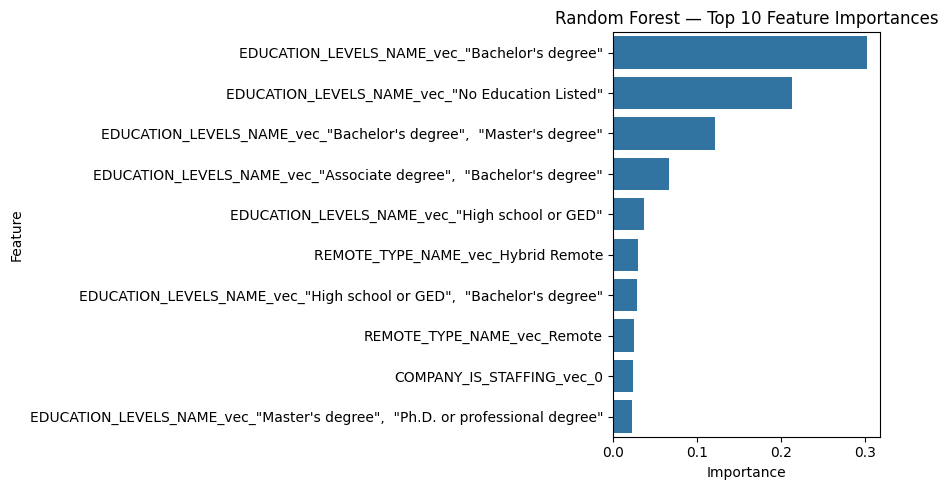

,feature,importance
0,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree""",0.302484
1,"EDUCATION_LEVELS_NAME_vec_""No Education Listed""",0.213539
2,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"",...",0.121585
6,"EDUCATION_LEVELS_NAME_vec_""Associate degree"", ...",0.067309
5,"EDUCATION_LEVELS_NAME_vec_""High school or GED""",0.036985
22,REMOTE_TYPE_NAME_vec_Hybrid Remote,0.030161
3,"EDUCATION_LEVELS_NAME_vec_""High school or GED""...",0.029165
21,REMOTE_TYPE_NAME_vec_Remote,0.025532
24,COMPANY_IS_STAFFING_vec_0,0.023729
14,"EDUCATION_LEVELS_NAME_vec_""Master's degree"", ...",0.022501


In [52]:
# Extract human-readable names from the features vector metadata
meta = regression_train.schema["features"].metadata
names = []

if "ml_attr" in meta and "attrs" in meta["ml_attr"]:
    attrs = meta["ml_attr"]["attrs"]
    # keep order by idx
    for group in ["binary", "numeric"]:
        if group in attrs:
            names.extend([a.get("name", f"features[{a['idx']}]")
                          for a in sorted(attrs[group], key=lambda x: x["idx"])])
elif "ml_attr" in meta and "num_attrs" in meta["ml_attr"]:
    # only size is known
    size = meta["ml_attr"]["num_attrs"]
    names = [f"features[{i}]" for i in range(size)]
else:
    # ultimate fallback
    names = [f"features[{i}]" for i in range(rf_model.numFeatures)]

# Make sure lengths align
if len(names) != rf_model.numFeatures:
    names = [f"features[{i}]" for i in range(rf_model.numFeatures)]

# Build the top-10 table and plot
importances = rf_model.featureImportances.toArray()
imp_df = (pd.DataFrame({"feature": names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(10))

plt.figure(figsize=(9, 5))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Random Forest — Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("output/rf_feature_importance.png", dpi=200)
plt.show()
plt.close()



imp_df  # shows the names + scores

# 7. Compare 3 Models – GLR, Polynomial, RF

In [56]:
# ==== STEP 7: Compare GLR (Linear), Polynomial, and Random Forest ====
from pyspark.sql import functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import pow, col
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os

# ------------- 1) Make predictions on the SAME test rows ----------------
# GLR & RF can predict directly on regression_test
glr_pred = glr_model.transform(regression_test) \
    .select(F.col("SALARY"), F.col("prediction").alias("pred_glr"))

rf_pred  = rf_model.transform(regression_test) \
    .select(F.col("SALARY"), F.col("prediction").alias("pred_rf"))

# For Polynomial: build `features_poly` on regression_test using your existing assembler_poly
reg_test_poly = (
    regression_test
    .withColumn("MAX_YEARS_EXPERIENCE_SQ", pow(col("MAX_YEARS_EXPERIENCE"), 2))
)
reg_test_poly = assembler_poly.transform(reg_test_poly)

poly_pred = poly_glr_max_years_model.transform(reg_test_poly) \
    .select(F.col("SALARY"), F.col("prediction").alias("pred_poly"))

# Merge the three predictions for plotting later (all rows are from regression_test)
pred_all = glr_pred.join(poly_pred, on=["SALARY"]).join(rf_pred, on=["SALARY"])

# ------------- 2) Metrics: RMSE, MAE, R² ----------------
def eval_metrics(df, label="SALARY", pred_col="prediction"):
    e = RegressionEvaluator(labelCol=label, predictionCol=pred_col)
    rmse = e.setMetricName("rmse").evaluate(df.select(label, pred_col))
    mae  = e.setMetricName("mae").evaluate(df.select(label, pred_col))
    r2   = e.setMetricName("r2").evaluate(df.select(label, pred_col))
    return rmse, mae, r2

rmse_glr,  mae_glr,  r2_glr  = eval_metrics(glr_pred,  "SALARY", "pred_glr")
rmse_poly, mae_poly, r2_poly = eval_metrics(poly_pred, "SALARY", "pred_poly")
rmse_rf,   mae_rf,   r2_rf   = eval_metrics(rf_pred,   "SALARY", "pred_rf")

# ------------- 3) AIC & BIC for linear models (RF has no likelihood) ----
aic_glr  = float(glr_model.summary.aic)
aic_poly = float(poly_glr_max_years_model.summary.aic)

def calc_bic(summary, model, n_fallback=None):
    # assignment formula
    try:
        n = summary.numInstances
    except Exception:
        n = n_fallback if n_fallback is not None else None
    if n is None:
        # safe fallback: count rows from the evaluation DF
        n = glr_pred.count()
    k = len(model.coefficients) + 1
    dispersion = float(summary.dispersion)
    deviance   = float(summary.deviance)
    loglik = -0.5 * ( n * np.log(2*np.pi) + n * np.log(dispersion) + (deviance/dispersion) )
    return k * np.log(n) - 2 * loglik

bic_glr  = calc_bic(glr_model.summary,              glr_model,              n_fallback=glr_pred.count())
bic_poly = calc_bic(poly_glr_max_years_model.summary, poly_glr_max_years_model, n_fallback=poly_pred.count())

aic_rf, bic_rf = np.nan, np.nan



In [57]:
# ------------- 4) Metrics table ----------------------------------------
metrics_df = pd.DataFrame([
    ["GLR (Linear)",     rmse_glr,  mae_glr,  r2_glr,  aic_glr,  bic_glr],
    ["Polynomial (LR)",  rmse_poly, mae_poly, r2_poly, aic_poly, bic_poly],
    ["Random Forest",    rmse_rf,   mae_rf,   r2_rf,   aic_rf,   bic_rf],
], columns=["Model","RMSE","MAE","R²","AIC","BIC"])

display(metrics_df)

# Save metrics
os.makedirs("output", exist_ok=True)
metrics_df.to_csv("output/model_metrics.csv", index=False)
print("Saved metrics to output/model_metrics.csv")

,Model,RMSE,MAE,R²,AIC,BIC
0,GLR (Linear),21796.247867,15335.765955,0.210636,114772.925815,114960.233511
1,Polynomial (LR),21640.793285,15143.070367,0.221855,114711.023658,114904.862205
2,Random Forest,20944.299982,14451.278651,0.271137,NaN,NaN


Saved metrics to output/model_metrics.csv


# 7.1 Calculating Log-Likelihood and BIC for PySpark Models

In [23]:
# code here

# 7.2 Evaluation Metrics